In [54]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [72]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asinow/diabetes-dataset")


# Prepping data

Our goal is to predict diabetes or not (Outcome = 1 or 0 respectively) and we'll try out XGBoost.

Dataset details available here: https://www.kaggle.com/datasets/asinow/diabetes-dataset?resource=download

In [10]:
data = pd.read_csv(path + "\\diabetes_dataset.csv")

In [11]:
data.head()

,Age,Pregnancies,BMI,Glucose,BloodPressure,HbA1c,LDL,HDL,Triglycerides,WaistCircumference,HipCircumference,WHR,FamilyHistory,DietType,Hypertension,MedicationUse,Outcome
0,69,5,28.39,130.1,77.0,5.4,130.4,44.0,50.0,90.5,107.9,0.84,0,0,0,1,0
1,32,1,26.49,116.5,72.0,4.5,87.4,54.2,129.9,113.3,81.4,1.39,0,0,0,0,0
2,89,13,25.34,101.0,82.0,4.9,112.5,56.8,177.6,84.7,107.2,0.79,0,0,0,1,0
3,78,13,29.91,146.0,104.0,5.7,50.7,39.1,117.0,108.9,110.0,0.99,0,0,0,1,1
4,38,8,24.56,103.2,74.0,4.7,102.5,29.1,145.9,84.1,92.8,0.91,0,1,0,0,0


In [14]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9538 entries, 0 to 9537
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 9538 non-null   int64  
 1   Pregnancies         9538 non-null   int64  
 2   BMI                 9538 non-null   float64
 3   Glucose             9538 non-null   float64
 4   BloodPressure       9538 non-null   float64
 5   HbA1c               9538 non-null   float64
 6   LDL                 9538 non-null   float64
 7   HDL                 9538 non-null   float64
 8   Triglycerides       9538 non-null   float64
 9   WaistCircumference  9538 non-null   float64
 10  HipCircumference    9538 non-null   float64
 11  WHR                 9538 non-null   float64
 12  FamilyHistory       9538 non-null   int64  
 13  DietType            9538 non-null   int64  
 14  Hypertension        9538 non-null   int64  
 15  MedicationUse       9538 non-null   int64  
 16  Outcom

In [15]:
print(data.describe())

               Age  Pregnancies          BMI      Glucose  BloodPressure  \
count  9538.000000  9538.000000  9538.000000  9538.000000    9538.000000   
mean     53.577584     7.986161    27.052364   106.104183      84.475781   
std      20.764651     4.933469     5.927955    21.918590      14.123480   
min      18.000000     0.000000    15.000000    50.000000      60.000000   
25%      36.000000     4.000000    22.870000    91.000000      74.000000   
50%      53.000000     8.000000    27.050000   106.000000      84.000000   
75%      72.000000    12.000000    31.180000   121.000000      94.000000   
max      89.000000    16.000000    49.660000   207.200000     138.000000   

             HbA1c          LDL          HDL  Triglycerides  \
count  9538.000000  9538.000000  9538.000000    9538.000000   
mean      4.650661   100.133456    49.953418     151.147746   
std       0.476395    29.911910    15.242194      48.951627   
min       4.000000   -12.000000    -9.200000      50.000000   


We'll need to remove the negative values for HDL and LDL. As these represent levels of lipoprotein in the blood, they can't be negative.

In [23]:
# There are only a few rows with negative values so I'll just drop them.
print(f"There are {len(data[data['LDL'] <0])} rows where LDL is negative.")
print(f"There are {len(data[data['HDL'] <0])} rows where HDL is negative.")


data = data[(data['LDL'] >= 0) & (data['HDL'] >= 0)]

data.reset_index(drop=True, inplace=True)

print(f"There are {len(data[(data['LDL'] < 0) | (data['HDL'] < 0)])} remaining rows where HDL or LDL is negative.")

There are 5 rows where LDL is negative.
There are 6 rows where HDL is negative.
There are 0 remaining rows where HDL or LDL is negative.


Features do not need to be normalized because XGBoost w/ classification is a tree-based algorithm which splits data on thresholds rather than absolute values.

We'll check to see if the target feature is balanced or not.

In [27]:
zeroes = data['Outcome'].value_counts()[0]
ones = data['Outcome'].value_counts()[1]

print(f"There are {zeroes} 0 target values, and {ones}.\nA ratio of {zeroes/ones}:1.")

There are 6247 0 target values, and 3280.
A ratio of 1.9045731707317073:1.


There are roughly twice the number of 0's as 1's, so we may want to add a weight to account for this.

From the dataset description, the values 0, 1, 2 in the DietType feature represent unbalanced, balance, and vegan/vegetarian respectively. Because these are categorical values, we'll one-hot encode them.

In [29]:
print(f"Values of DietType feature: {data['DietType'].unique()}")

Values of DietType feature: [0 1 2]


In [30]:
data = pd.get_dummies(data, columns=['DietType'], prefix='DietType')

In [33]:
data[['DietType_0', 'DietType_1', 'DietType_2']]

,DietType_0,DietType_1,DietType_2
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,False,True,False
...,...,...,...
9522,True,False,False
9523,True,False,False
9524,True,False,False
9525,True,False,False


Split into X and y and test/train sets

In [57]:
X = data.drop(columns = ['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 69, stratify = y)

Remember, our dataset is imbalanced. We'll calculate weights for each class using the scale_pos_weight parameter. It's not highly imbalanced so we done need to use inverse frequency.

In [58]:
scale_pos_weight = zeroes/ones # We calculated the number of each class earlier

In [59]:
# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Training time!

In [60]:

params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",  # Log loss for classification
    "max_depth": 6,
    "learning_rate": 0.1,
    "scale_pos_weight" : scale_pos_weight
}

start_time = time.time()

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "Test")])

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds")

[0]	Test-logloss:0.59833
[1]	Test-logloss:0.52060
[2]	Test-logloss:0.45582
[3]	Test-logloss:0.40100
[4]	Test-logloss:0.35422
[5]	Test-logloss:0.31387
[6]	Test-logloss:0.27887
[7]	Test-logloss:0.24834
[8]	Test-logloss:0.22163
[9]	Test-logloss:0.19808
[10]	Test-logloss:0.17730
[11]	Test-logloss:0.15893
[12]	Test-logloss:0.14263
[13]	Test-logloss:0.12813
[14]	Test-logloss:0.11521
[15]	Test-logloss:0.10368
[16]	Test-logloss:0.09338
[17]	Test-logloss:0.08415
[18]	Test-logloss:0.07589
[19]	Test-logloss:0.06847
[20]	Test-logloss:0.06182
[21]	Test-logloss:0.05584
[22]	Test-logloss:0.05046
[23]	Test-logloss:0.04563
[24]	Test-logloss:0.04125
[25]	Test-logloss:0.03731
[26]	Test-logloss:0.03375
[27]	Test-logloss:0.03057
[28]	Test-logloss:0.02768
[29]	Test-logloss:0.02507
[30]	Test-logloss:0.02272
[31]	Test-logloss:0.02060
[32]	Test-logloss:0.01868
[33]	Test-logloss:0.01696
[34]	Test-logloss:0.01541
[35]	Test-logloss:0.01401
[36]	Test-logloss:0.01273
[37]	Test-logloss:0.01158
[38]	Test-logloss:0.01

In [61]:
# and check it!

y_pred = model.predict(dtest)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9995


Wow! Great accuracy!
We'll do a confusion matrix too for fun.

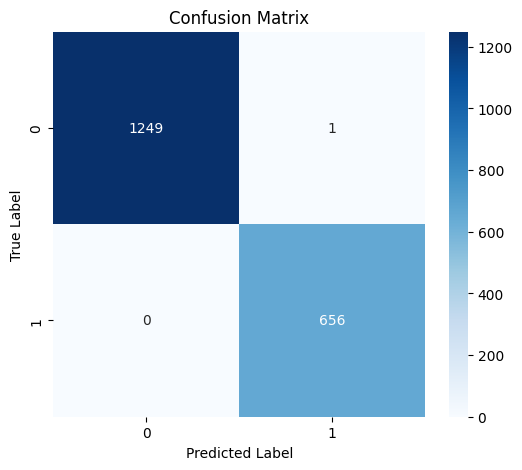

In [62]:
cm = confusion_matrix(y_test, y_pred_binary)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Neat! Only one incorrect prediction.

How about we create a balanced dataset with SMOTE (Synthetic Minority Oversampling Technique) to see if it generalizes well?

In [68]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=69)

X_resampled, y_resampled = smote.fit_resample(X, y)

dtest_balanced = xgb.DMatrix(X_resampled, label = y_resampled)

ones_balanced = sum(y_resampled)
zeroes_balanced = len(y_resampled) - ones_balanced

print(f"There are {zeroes_balanced} rows that belong to class 0, a ratio of {zeroes_balanced/ones_balanced:.0f}:1")

There are 6247 rows that belong to class 0, a ratio of 1:1


In [69]:
y_pred_balanced = model.predict(dtest_balanced)
y_pred_binary_balanced = [1 if p > 0.5 else 0 for p in y_pred_balanced]

accuracy_balanced = accuracy_score(y_resampled, y_pred_binary_balanced)
print(f"Accuracy: {accuracy_balanced:.4f}")

Accuracy: 0.9936


Still really good! For fun, let's try retraining and retesting both datasets *without* class weights.

In [73]:

params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",  # Log loss for classification
    "max_depth": 6,
    "learning_rate": 0.1
}

start_time = time.time()

model = xgb.train(params, dtrain, num_boost_round=100, evals=[(dtest, "Test")], verbose_eval=0)

end_time = time.time()

print(f"Training time: {end_time - start_time:.2f} seconds\n")

y_pred = model.predict(dtest)
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

Training time: 0.06 seconds

Accuracy: 0.9995


In [74]:
y_pred_balanced = model.predict(dtest_balanced)
y_pred_binary_balanced = [1 if p > 0.5 else 0 for p in y_pred_balanced]

accuracy_balanced = accuracy_score(y_resampled, y_pred_binary_balanced)
print(f"Accuracy: {accuracy_balanced:.4f}")

Accuracy: 0.9936


Interesting. No change in accuracy, granted the dataset was not *that* imbalanced. 